<a href="https://colab.research.google.com/github/joseenrico/Analysis-Data/blob/main/Skripsi_Analisis_Sentimen_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install vaderSentiment

import pandas as pd
import numpy as np
import nltk
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/DevinCrawling.xlsx')
display(data)

,description
0,bisous
1,Dear Scott. You are a scammer. And i hope you ...
2,It’s life a for being software engineer being ...
3,What is the 255^2 mi- Scott: 5000. 5000 is the...
4,Do you ages platform that I can try to design ...
...,...
1822,"And if the debug statement output reads ""abort..."
1823,"Request: I'm a human software engineer too, an..."
1824,🥳👏
1825,I was here


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  1826 non-null   object
dtypes: object(1)
memory usage: 14.4+ KB


In [ ]:
#Mengecek Apakah Ada data null atau kosong
data.isnull().sum()

description    1
dtype: int64

In [ ]:
#Menghapus data jika merupakan duplikat
data.drop_duplicates(inplace=True)
display(data)

,description
0,bisous
1,Dear Scott. You are a scammer. And i hope you ...
2,It’s life a for being software engineer being ...
3,What is the 255^2 mi- Scott: 5000. 5000 is the...
4,Do you ages platform that I can try to design ...
...,...
1821,..and most likely saw your comment and made th...
1822,"And if the debug statement output reads ""abort..."
1824,🥳👏
1825,I was here


In [ ]:
data['description'] = data['description'].astype(str)

In [ ]:
data.shape

(1798, 1)

# LABELLING

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def analisis_sentimen(description):
  description = re.sub(r'[^\w\s]', '', description)  # Hapus karakter non-alfanumerik dan spasi
  sentimen = analyzer.polarity_scores(description)
  skor_compound = sentimen['compound']  # Ekstrak skor compound untuk sentimen keseluruhan
  if skor_compound > 0:  # Ambang batas untuk sentimen positif
    return 'Positif'
  elif skor_compound <= 0:  # Ambang batas untuk sentimen negatif
    return 'Negatif'

# Menerapkan fungsi pada kolom teks
data['Sentimen'] = data['description'].apply(analisis_sentimen)
display(data)

,description,Sentimen
0,bisous,Negatif
1,Dear Scott. You are a scammer. And i hope you ...,Positif
2,It’s life a for being software engineer being ...,Negatif
3,What is the 255^2 mi- Scott: 5000. 5000 is the...,Negatif
4,Do you ages platform that I can try to design ...,Negatif
...,...,...
1821,..and most likely saw your comment and made th...,Positif
1822,"And if the debug statement output reads ""abort...",Negatif
1824,🥳👏,Negatif
1825,I was here,Negatif


# EDA

Positive sentiment: 668
Negative sentiment: 1130


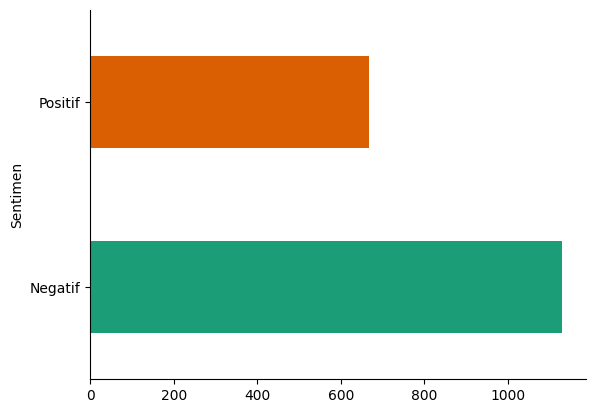

In [ ]:
# BarPlot
data.groupby('Sentimen').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

positive_count = data[data['Sentimen'] == 'Positif'].shape[0]
negative_count = data[data['Sentimen'] == 'Negatif'].shape[0]

print(f"Positive sentiment: {positive_count}")
print(f"Negative sentiment: {negative_count}")

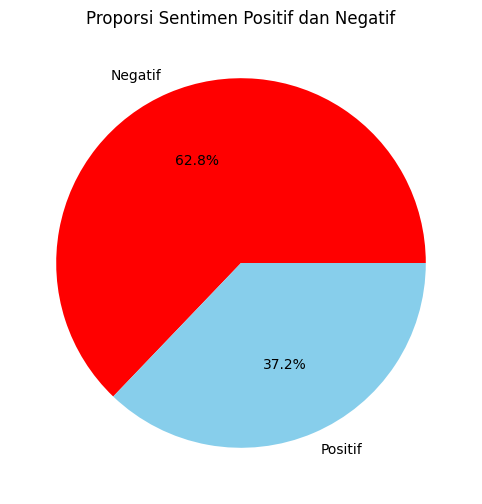

Positive sentiment: 668
Negative sentiment: 1130


In [ ]:
# Menghitung jumlah sentimen positif dan negatif
sentiment_counts = data['Sentimen'].value_counts()

# Plot pie chart dengan warna yang lebih lembut
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'skyblue'])
plt.title('Proporsi Sentimen Positif dan Negatif')
plt.show()

# Menghitung dan menampilkan jumlah sentimen positif dan negatif
positive_count = data[data['Sentimen'] == 'Positif'].shape[0]
negative_count = data[data['Sentimen'] == 'Negatif'].shape[0]

print(f"Positive sentiment: {positive_count}")
print(f"Negative sentiment: {negative_count}")


# PRE-PROCESSING DATA

## CASE FOLDING

In [ ]:
#Merubah semua huruf data menjadi huruf kecil
data['After_teks'] = data['description'].str.lower()

display(data)

,description,Sentimen,After_teks
0,bisous,Negatif,bisous
1,Dear Scott. You are a scammer. And i hope you ...,Positif,dear scott. you are a scammer. and i hope you ...
2,It’s life a for being software engineer being ...,Negatif,it’s life a for being software engineer being ...
3,What is the 255^2 mi- Scott: 5000. 5000 is the...,Negatif,what is the 255^2 mi- scott: 5000. 5000 is the...
4,Do you ages platform that I can try to design ...,Negatif,do you ages platform that i can try to design ...
...,...,...,...
1821,..and most likely saw your comment and made th...,Positif,..and most likely saw your comment and made th...
1822,"And if the debug statement output reads ""abort...",Negatif,"and if the debug statement output reads ""abort..."
1824,🥳👏,Negatif,🥳👏
1825,I was here,Negatif,i was here


## CLEANSING

In [ ]:
# Menghapus mention username, link, hashtag, dan URL
pattern = r"(?:\@[\w\-]+\s?)|(?:https?:\/\/[\w\-\.]+\/[\w\-\.]+\/[\w\-\.]+.*?)(?:\s|$)"
data['After_teks'] = data['After_teks'].apply(lambda text: re.sub(pattern, '', text))

# Menghilangkan karakter selain a-z seperti simbol, spasi berlebih
simbol = r"[^\w\s]"
data['After_teks'] = data['After_teks'].apply(lambda text: re.sub(simbol, '', text))

# Fungsi untuk menghapus kata dengan panjang kurang dari tiga huruf
def remove_short_words(text):
    return ' '.join([word for word in text.split() if len(word) > 2])

data['After_teks'] = data['After_teks'].apply(remove_short_words)

# Menghapus baris yang isinya kosong
data = data[data['After_teks'].str.strip().astype(bool)]

# Menyimpan hasil pada kolom 'description'
data = data.assign(**{"description": data['After_teks']})

# Menampilkan data
data.reset_index(drop=True, inplace=True)
display(data)

,description,Sentimen,After_teks
0,bisous,Negatif,bisous
1,dear scott you are scammer and hope you scam a...,Positif,dear scott you are scammer and hope you scam a...
2,its life for being software engineer being rep...,Negatif,its life for being software engineer being rep...
3,what the 2552 scott 5000 5000 the correct answer,Negatif,what the 2552 scott 5000 5000 the correct answer
4,you ages platform that can try design software...,Negatif,you ages platform that can try design software...
...,...,...,...
1762,lol,Positif,lol
1763,and most likely saw your comment and made the ...,Positif,and most likely saw your comment and made the ...
1764,and the debug statement output reads abort ret...,Negatif,and the debug statement output reads abort ret...
1765,was here,Negatif,was here


# LEMMATIZATION

In [ ]:
#Mengubah kata-kata dalam data teks menjadi kata dasar
lemmatizer = WordNetLemmatizer()

# Fungsi untuk mendapatkan tag POS untuk lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Fungsi untuk lemmatization dengan POS
def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

data = data.assign(**{"description": data['After_teks']})

data['After_teks'] = data['After_teks'].apply(lemmatize_text)

display(data)

,description,Sentimen,After_teks
0,bisous,Negatif,bisous
1,dear scott you are scammer and hope you scam a...,Positif,dear scott you be scammer and hope you scam al...
2,its life for being software engineer being rep...,Negatif,it life for be software engineer be replace ju...
3,what the 2552 scott 5000 5000 the correct answer,Negatif,what the 2552 scott 5000 5000 the correct answer
4,you ages platform that can try design software...,Negatif,you age platform that can try design software ...
...,...,...,...
1762,lol,Positif,lol
1763,and most likely saw your comment and made the ...,Positif,and most likely saw your comment and make the ...
1764,and the debug statement output reads abort ret...,Negatif,and the debug statement output read abort retr...
1765,was here,Negatif,be here


# STOPWORDS

In [ ]:
# Inisialisasi stopwords bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

data = data.assign(**{"description": data['After_teks']})

# Menghilangkan stopwords pada data
data['After_teks'] = data['After_teks'].apply(remove_stopwords)

# Menampilkan data
display(data)

,description,Sentimen,After_teks
0,bisous,Negatif,bisous
1,dear scott you be scammer and hope you scam al...,Positif,dear scott scammer hope scam vcs pretty well q...
2,it life for be software engineer be replace ju...,Negatif,life software engineer replace imagine
3,what the 2552 scott 5000 5000 the correct answer,Negatif,2552 scott 5000 5000 correct answer
4,you age platform that can try design software ...,Negatif,age platform try design software application b...
...,...,...,...
1762,lol,Positif,lol
1763,and most likely saw your comment and make the ...,Positif,likely saw comment make next debugging quicker...
1764,and the debug statement output read abort retr...,Negatif,debug statement output read abort retry fail w...
1765,be here,Negatif,


# TOKENIZATION

In [ ]:
data = data.assign(**{"description": data['After_teks']})

#Mengubah Kalimat dalam data teks menjadi token per kata
def tokenize_text(text):
  return word_tokenize(text)

data['After_teks'] = data['After_teks'].apply(tokenize_text)
display(data)

,description,Sentimen,After_teks
0,bisous,Negatif,[bisous]
1,dear scott scammer hope scam vcs pretty well q...,Positif,"[dear, scott, scammer, hope, scam, vcs, pretty..."
2,life software engineer replace imagine,Negatif,"[life, software, engineer, replace, imagine]"
3,2552 scott 5000 5000 correct answer,Negatif,"[2552, scott, 5000, 5000, correct, answer]"
4,age platform try design software application b...,Negatif,"[age, platform, try, design, software, applica..."
...,...,...,...
1762,lol,Positif,[lol]
1763,likely saw comment make next debugging quicker...,Positif,"[likely, saw, comment, make, next, debugging, ..."
1764,debug statement output read abort retry fail w...,Negatif,"[debug, statement, output, read, abort, retry,..."
1765,,Negatif,[]


# WORD CLOUD

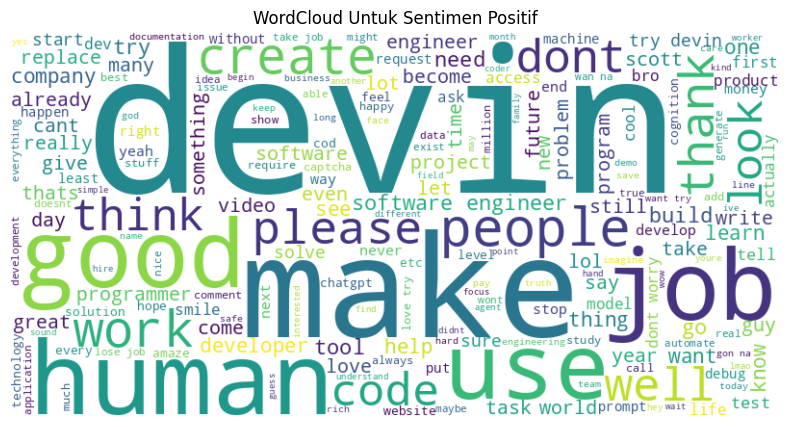

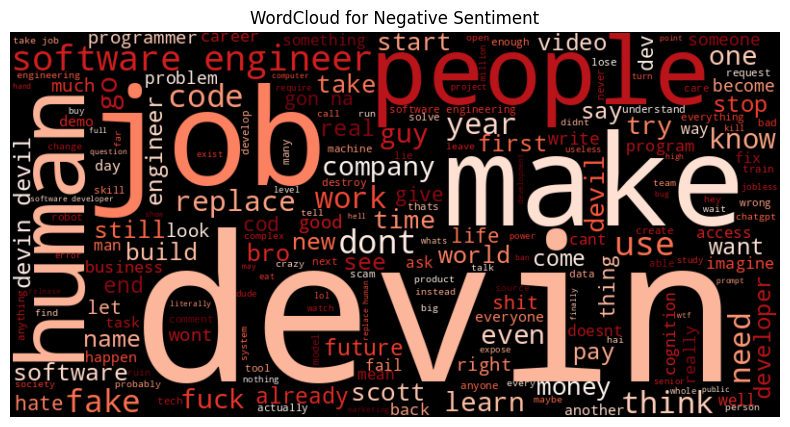

In [ ]:
# Pisahkan teks berdasarkan label sentimen
positive_text = " ".join(data[data['Sentimen'] == 'Positif']['description'])
negative_text = " ".join(data[data['Sentimen'] == 'Negatif']['description'])

# Generate WordCloud untuk sentimen positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Tampilkan WordCloud positif
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Untuk Sentimen Positif')
plt.show()

# Generate WordCloud untuk sentimen negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Tampilkan WordCloud negatif
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Negative Sentiment')
plt.show()

10 Kata yang Paling Sering Muncul untuk Sentimen Positif:
devin       226
like        123
job          94
make         90
software     84
would        80
try          79
human        76
engineer     68
good         66
dtype: int64
10 Kata yang Paling Sering Muncul untuk Sentimen Negatif:
devin       283
software    114
job         112
engineer     89
make         78
human        77
people       72
get          69
use          59
devil        59
dtype: int64


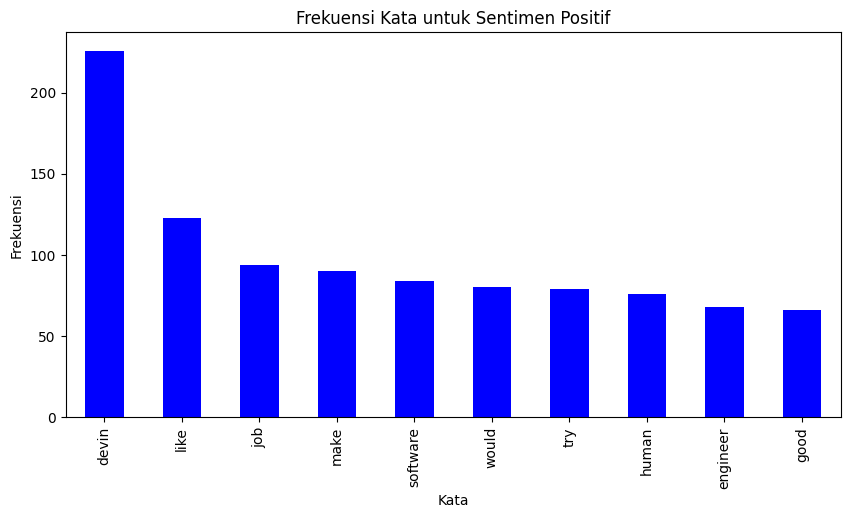

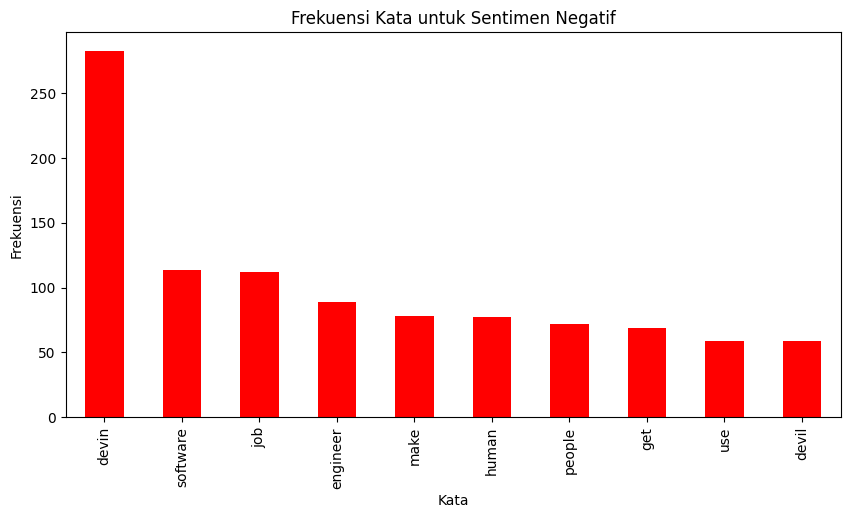

In [ ]:
# Konversi semua elemen dalam kolom 'description' menjadi string
# data['description'] = data['description'].astype(str)

# Pisahkan teks berdasarkan label sentimen
positive_texts = data[data['Sentimen'] == 'Positif']['description']
negative_texts = data[data['Sentimen'] == 'Negatif']['description']

# Gunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer()

# Frekuensi kata untuk sentimen positif
positive_counts = vectorizer.fit_transform(positive_texts)
positive_word_freq = pd.DataFrame(positive_counts.toarray(), columns=vectorizer.get_feature_names_out())
positive_word_freq = positive_word_freq.sum(axis=0).sort_values(ascending=False)

# Frekuensi kata untuk sentimen negatif
negative_counts = vectorizer.fit_transform(negative_texts)
negative_word_freq = pd.DataFrame(negative_counts.toarray(), columns=vectorizer.get_feature_names_out())
negative_word_freq = negative_word_freq.sum(axis=0).sort_values(ascending=False)

# Tampilkan 10 kata yang paling sering muncul untuk sentimen positif
print("10 Kata yang Paling Sering Muncul untuk Sentimen Positif:")
print(positive_word_freq.head(10))

# Tampilkan 10 kata yang paling sering muncul untuk sentimen negatif
print("10 Kata yang Paling Sering Muncul untuk Sentimen Negatif:")
print(negative_word_freq.head(10))

# Plot Word Frequency untuk Sentimen Positif
plt.figure(figsize=(10, 5))
positive_word_freq.head(10).plot(kind='bar', color='blue')
plt.title('Frekuensi Kata untuk Sentimen Positif')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.show()

# Plot Word Frequency untuk Sentimen Negatif
plt.figure(figsize=(10, 5))
negative_word_freq.head(10).plot(kind='bar', color='red')
plt.title('Frekuensi Kata untuk Sentimen Negatif')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.show()


10 Kata yang Paling Sering Muncul untuk Sentimen Positif (TF-IDF):
devin     35.988460
try       25.297857
like      24.589312
would     19.642681
job       15.883020
want      15.803915
good      15.085443
please    15.012241
use       14.205471
make      13.949461
dtype: float64
10 Kata yang Paling Sering Muncul untuk Sentimen Negatif (TF-IDF):
devin       66.606922
devil       34.118769
software    24.586022
engineer    22.088575
job         22.047683
fake        20.211861
human       17.592861
scam        17.185532
make        16.971170
get         16.717961
dtype: float64


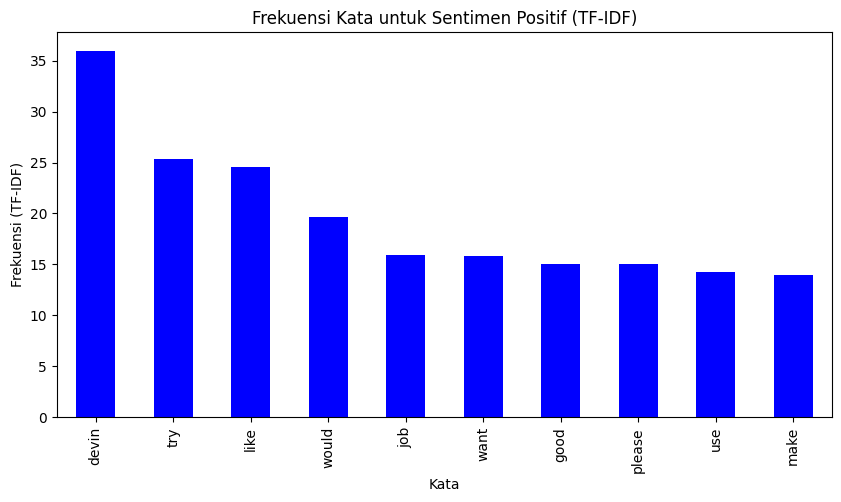

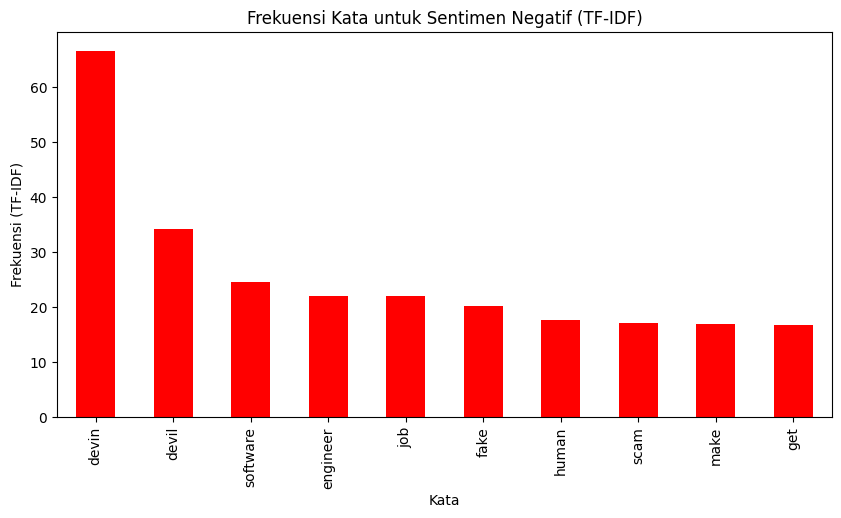

In [ ]:


# Konversi semua elemen dalam kolom 'description' menjadi string
# data['description'] = data['description'].astype(str)

# Pisahkan teks berdasarkan label sentimen
positive_texts = data[data['Sentimen'] == 'Positif']['description']
negative_texts = data[data['Sentimen'] == 'Negatif']['description']

# Gunakan TfidfVectorizer untuk menghitung frekuensi kata
vectorizer = TfidfVectorizer(max_features=5000)

# Frekuensi kata untuk sentimen positif
positive_tfidf = vectorizer.fit_transform(positive_texts)
positive_word_tfidf = pd.DataFrame(positive_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
positive_word_tfidf = positive_word_tfidf.sum(axis=0).sort_values(ascending=False)

# Frekuensi kata untuk sentimen negatif
negative_tfidf = vectorizer.fit_transform(negative_texts)
negative_word_tfidf = pd.DataFrame(negative_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
negative_word_tfidf = negative_word_tfidf.sum(axis=0).sort_values(ascending=False)

# Tampilkan 10 kata yang paling sering muncul untuk sentimen positif berdasarkan TF-IDF
print("10 Kata yang Paling Sering Muncul untuk Sentimen Positif (TF-IDF):")
print(positive_word_tfidf.head(10))

# Tampilkan 10 kata yang paling sering muncul untuk sentimen negatif berdasarkan TF-IDF
print("10 Kata yang Paling Sering Muncul untuk Sentimen Negatif (TF-IDF):")
print(negative_word_tfidf.head(10))

# Plot Word Frequency untuk Sentimen Positif berdasarkan TF-IDF
plt.figure(figsize=(10, 5))
positive_word_tfidf.head(10).plot(kind='bar', color='blue')
plt.title('Frekuensi Kata untuk Sentimen Positif (TF-IDF)')
plt.xlabel('Kata')
plt.ylabel('Frekuensi (TF-IDF)')
plt.show()

# Plot Word Frequency untuk Sentimen Negatif berdasarkan TF-IDF
plt.figure(figsize=(10, 5))
negative_word_tfidf.head(10).plot(kind='bar', color='red')
plt.title('Frekuensi Kata untuk Sentimen Negatif (TF-IDF)')
plt.xlabel('Kata')
plt.ylabel('Frekuensi (TF-IDF)')
plt.show()


# EVALUASI CONFUSION MATRIX SVM

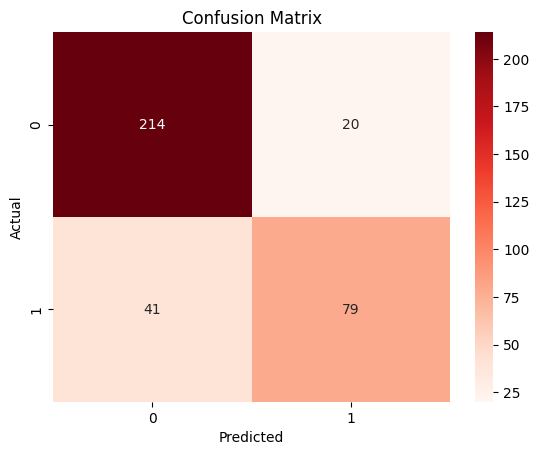

              precision    recall  f1-score   support

     Negatif       0.84      0.91      0.88       234
     Positif       0.80      0.66      0.72       120

    accuracy                           0.83       354
   macro avg       0.82      0.79      0.80       354
weighted avg       0.83      0.83      0.82       354

Total number of test samples: 354
True Positif (TP): 79
True Negatif (TN): 214
False Positif (FP): 20
False Negatif (FN): 41
Jumlah sampel yang terprediksi sebagai sentimen Negatif: 255
Jumlah sampel yang terprediksi sebagai sentimen Positif: 99


In [ ]:
X = data['description']
y = data['Sentimen']

# Membuat pipeline untuk vektorisasi teks dan pelatihan SVM
pipeline = make_pipeline(TfidfVectorizer(max_features=2000), SVC(kernel='linear'))

# Split the data for initial model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model SVM
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Menghitung persentase
total = tn + fp + fn + tp
positive_percentage = (tp + fn) / total * 100
negative_percentage = (tn + fp) / total * 100

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

print(f'Total number of test samples: {len(y_test)}')

# Print Confusion Matrix values
print(f'True Positif (TP): {tp}')
print(f'True Negatif (TN): {tn}')
print(f'False Positif (FP): {fp}')
print(f'False Negatif (FN): {fn}')

# Menghitung jumlah sampel yang terprediksi sebagai sentimen negatif dan positif
negatif_prediksi = (y_pred == 'Negatif').sum()
positif_prediksi = (y_pred == 'Positif').sum()

# Menampilkan hasil
print(f'Jumlah sampel yang terprediksi sebagai sentimen Negatif: {negatif_prediksi}')
print(f'Jumlah sampel yang terprediksi sebagai sentimen Positif: {positif_prediksi}')


# K-FOLD CROSS VALIDATION

In [ ]:
# Inisialisasi KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Untuk menyimpan hasil akurasi setiap fold
accuracies = []

# Untuk menyimpan prediksi dan label aktual dari setiap fold
y_true_all = []
y_pred_all = []

# Lakukan K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Print accuracies for each fold
for i, acc in enumerate(accuracies, 1):
    print(f'Akurasi untuk fold {i}: {acc:.4f}')

# Print percentages
print(f'Persentase Positif: {positive_percentage:.2f}%')
print(f'Persentase Negatif: {negative_percentage:.2f}%')

Akurasi untuk fold 1: 0.8023
Akurasi untuk fold 2: 0.8588
Akurasi untuk fold 3: 0.7966
Akurasi untuk fold 4: 0.8249
Akurasi untuk fold 5: 0.8305
Akurasi untuk fold 6: 0.7966
Akurasi untuk fold 7: 0.8362
Akurasi untuk fold 8: 0.8807
Akurasi untuk fold 9: 0.8636
Akurasi untuk fold 10: 0.8011
Persentase Positif: 33.90%
Persentase Negatif: 66.10%


# CONFUSION MATRIX FOR K-FOLD CROSS VALIDATION

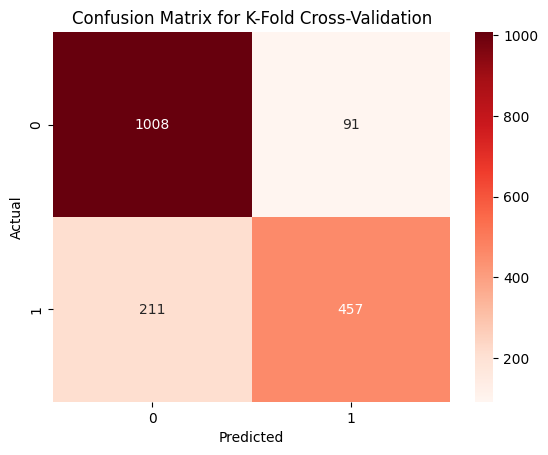

              precision    recall  f1-score   support

     Negatif       0.83      0.92      0.87      1099
     Positif       0.83      0.68      0.75       668

    accuracy                           0.83      1767
   macro avg       0.83      0.80      0.81      1767
weighted avg       0.83      0.83      0.83      1767

Total number of test samples: 1767
True Positif (TP): 457
True Negatif (TN): 1008
False Positif (FP): 91
False Negatif (FN): 211
Jumlah sampel yang terprediksi sebagai sentimen Negatif: 1219
Jumlah sampel yang terprediksi sebagai sentimen Positif: 548
Persentase Positif: 31.01%
Persentase Negatif: 68.99%


In [ ]:
X = data['description']
y = data['Sentimen']

# Inisialisasi LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Membuat pipeline untuk vektorisasi teks dan pelatihan SVM
pipeline = make_pipeline(TfidfVectorizer(max_features=2000), SVC(kernel='linear', probability=True))

# Inisialisasi KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Untuk menyimpan hasil akurasi setiap fold
accuracies = []

# Untuk menyimpan prediksi dan label aktual dari setiap fold
y_true_all = []
y_pred_all = []
y_scores_all = []

# Lakukan K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Melatih model SVM
    pipeline.fit(X_train, y_train)

    # Prediksi
    y_pred = pipeline.predict(X_test)
    y_scores = pipeline.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_scores_all.extend(y_scores)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Konversi ke numpy array untuk evaluasi
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_scores_all = np.array(y_scores_all)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
tn, fp, fn, tp = cm.ravel()

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for K-Fold Cross-Validation')
plt.show()

# Classification Report
print(classification_report(y_true_all, y_pred_all, target_names=['Negatif', 'Positif']))

# Print total number of test samples
print(f'Total number of test samples: {len(y_true_all)}')

# Print Confusion Matrix values
print(f'True Positif (TP): {tp}')
print(f'True Negatif (TN): {tn}')
print(f'False Positif (FP): {fp}')
print(f'False Negatif (FN): {fn}')

# Menghitung jumlah sampel yang terprediksi sebagai sentimen negatif dan positif
negatif_prediksi = (y_pred_all == 0).sum()
positif_prediksi = (y_pred_all == 1).sum()

# Menampilkan hasil
print(f'Jumlah sampel yang terprediksi sebagai sentimen Negatif: {negatif_prediksi}')
print(f'Jumlah sampel yang terprediksi sebagai sentimen Positif: {positif_prediksi}')

# Menghitung persentase
total = len(y_true_all)
positive_percentage = (positif_prediksi / total) * 100
negative_percentage = (negatif_prediksi / total) * 100

# Print percentages
print(f'Persentase Positif: {positive_percentage:.2f}%')
print(f'Persentase Negatif: {negative_percentage:.2f}%')

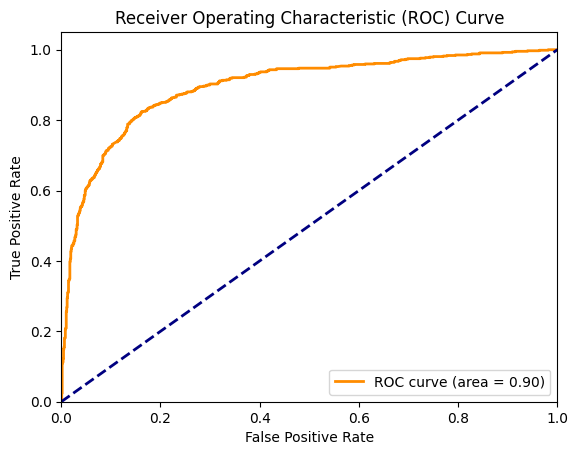

AUC: 0.90


In [ ]:
# ROC Curve dan AUC
fpr, tpr, thresholds = roc_curve(y_true_all, y_scores_all)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f'AUC: {roc_auc:.2f}')

In [ ]:
# #Menghapus kolom data yang tidak diperlukan
# data.drop(columns = ['conversation_id_str', 'favorite_count', 'id_str',	'image_url',	'in_reply_to_screen_name',	'lang',	'location',	'quote_count',	'reply_count',	'retweet_count',	'tweet_url',	'user_id_str',	'username'], inplace = True)
# data.columns = ['Tanggal', 'Teks']
# display(data)

#Agar susunan kolom menjadi rapih maka posisi kolom Sentimen dan After_teks akan di tukar
# pop = data.pop('After_teks')
# data.insert(2, 'After_teks', pop)

In [ ]:
# X = data['description']
# y = data['Sentimen']

# # Inisialisasi KFold
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # Membuat pipeline untuk vektorisasi teks dan pelatihan SVM
# pipeline = make_pipeline(TfidfVectorizer(max_features=5000), SVC(kernel='linear'))

# # Untuk menyimpan hasil akurasi setiap fold
# accuracies = []

# # Untuk menyimpan prediksi dan label aktual dari setiap fold
# y_true_all = []
# y_pred_all = []

# # Lakukan K-Fold Cross-Validation
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     y_true_all.extend(y_test)
#     y_pred_all.extend(y_pred)

#     acc = accuracy_score(y_test, y_pred)
#     accuracies.append(acc)

# # Print accuracies for each fold
# for i, acc in enumerate(accuracies, 1):
#     print(f'Akurasi untuk fold {i}: {acc:.4f}')

# # Menghitung Confusion Matrix untuk semua data dari K-Fold
# cm = confusion_matrix(y_true_all, y_pred_all)
# tn, fp, fn, tp = cm.ravel()

# # Plot Confusion Matrix
# sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix after K-Fold Cross-Validation')
# plt.show()

# # Classification Report
# print(classification_report(y_true_all, y_pred_all))

# # Print total number of test samples
# print(f'Total number of test samples: {len(y_true_all)}')

# # Print Confusion Matrix values
# print(f'True Positif (TP): {tp}')
# print(f'True Negatif (TN): {tn}')
# print(f'False Positif (FP): {fp}')
# print(f'False Negatif (FN): {fn}')

In [ ]:
# # Contoh data
# X = data['description']
# y = data['Sentimen']

# # Membuat pipeline untuk vektorisasi teks dan pelatihan SVM
# pipeline = make_pipeline(TfidfVectorizer(max_features=5000), SVC(kernel='linear', probability=True))

# # Split data untuk pelatihan awal dan evaluasi
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Melatih model SVM
# pipeline.fit(X_train, y_train)

# # Menghitung probabilitas prediksi dari model (probabilitas untuk kelas positif)
# y_scores = pipeline.predict_proba(X_test)[:, 1]  # Ambil probabilitas untuk kelas positif

In [ ]:
#KODE UNTUK STEMMER
# import nltk
# from nltk.stem import PorterStemmer

# # Pastikan resource sudah diunduh
# nltk.download('punkt')

# # Inisialisasi PorterStemmer
# stemmer = PorterStemmer()

# data = data.assign(**{"description": data['After_teks']})

# def stem_text(text):
#     return stemmer.stem(text)

# data['After_teks'] = data['After_teks'].apply(stem_text)
# display(data)


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np

# # Membuat pipeline untuk vektorisasi teks dan pelatihan SVM
# pipeline = make_pipeline(TfidfVectorizer(max_features=5000), SVC(kernel='linear'))

# # Menggunakan KFold cross-validation
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # Variabel untuk menyimpan hasil setiap fold
# all_fold_results = []

# for fold, (train_index, test_index) in enumerate(kf.split(X)):
#     # Membagi data menjadi train dan test berdasarkan indeks fold saat ini
#     X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
#     y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

#     # Melatih model pada data train fold saat ini
#     pipeline.fit(X_train_fold, y_train_fold)

#     # Melakukan prediksi pada data test fold saat ini
#     y_pred_fold = pipeline.predict(X_test_fold)

#     # Menghitung Confusion Matrix untuk fold saat ini
#     cm_fold = confusion_matrix(y_test_fold, y_pred_fold)
#     tn, fp, fn, tp = cm_fold.ravel()

#     # Menyimpan hasil fold saat ini ke dalam daftar
#     fold_results = {
#         'fold': fold + 1,
#         'true_positive': tp,
#         'true_negative': tn,
#         'false_positive': fp,
#         'false_negative': fn,
#         'accuracy': (tp + tn) / (tp + tn + fp + fn),
#         'classification_report': classification_report(y_test_fold, y_pred_fold, output_dict=True)
#     }
#     all_fold_results.append(fold_results)

#     # Menampilkan hasil Confusion Matrix untuk fold saat ini
#     sns.heatmap(cm_fold, annot=True, fmt='d', cmap='Reds')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title(f'Confusion Matrix - Fold {fold + 1}')
#     plt.show()

#     # Menampilkan Classification Report untuk fold saat ini
#     print(f'Classification Report - Fold {fold + 1}')
#     print(classification_report(y_test_fold, y_pred_fold))
#     print()

# # Menampilkan hasil keseluruhan dari semua fold
# for result in all_fold_results:
#     print(f"Fold {result['fold']}:")
#     print(f"  True Positif (TP): {result['true_positive']}")
#     print(f"  True Negatif (TN): {result['true_negative']}")
#     print(f"  False Positif (FP): {result['false_positive']}")
#     print(f"  False Negatif (FN): {result['false_negative']}")
#     print(f"  Accuracy: {result['accuracy']:.2f}")
#     print(f"  Classification Report:")
#     for label, metrics in result['classification_report'].items():
#         if isinstance(metrics, dict):
#             print(f"    {label}:")
#             for metric, value in metrics.items():
#                 print(f"      {metric}: {value:.2f}")
#         else:
#             print(f"    {label}: {metrics:.2f}")
#     print()

# # Menghitung rata-rata hasil dari semua fold
# avg_true_positive = np.mean([result['true_positive'] for result in all_fold_results])
# avg_true_negative = np.mean([result['true_negative'] for result in all_fold_results])
# avg_false_positive = np.mean([result['false_positive'] for result in all_fold_results])
# avg_false_negative = np.mean([result['false_negative'] for result in all_fold_results])
# avg_accuracy = np.mean([result['accuracy'] for result in all_fold_results])

# print(f'Rata-rata hasil dari semua fold:')
# print(f'  True Positif (TP): {avg_true_positive:.2f}')
# print(f'  True Negatif (TN): {avg_true_negative:.2f}')
# print(f'  False Positif (FP): {avg_false_positive:.2f}')
# print(f'  False Negatif (FN): {avg_false_negative:.2f}')
# print(f'  Accuracy: {avg_accuracy:.2f}')


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/DevinLastTest.xlsx')
display(data)

,description
0,bisous
1,Dear Scott. You are a scammer. And i hope you ...
2,It’s life a for being software engineer being ...
3,What is the 255^2 mi- Scott: 5000. 5000 is the...
4,Do you ages platform that I can try to design ...
...,...
1822,"And if the debug statement output reads ""abort..."
1823,"Request: I'm a human software engineer too, an..."
1824,🥳👏
1825,I was here
